In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as TF
import keras
import cv2
from typing import Tuple
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CATEGORIES = ["NORMAL", "PNEUMONIA"]
EPOCHS = 80
TEST_SET = 0.3

In [108]:
def LoadDataFromDirectory(dataDir : str):
    images = []
    labels = []
    for Category in CATEGORIES:
        singleCategory = os.path.join(dataDir, str(Category))
        
        for image in os.listdir(singleCategory):
            imgPaths = os.path.join(singleCategory, image)
            
            finalImage = cv2.imread(imgPaths)
            
            if finalImage is None:
                raise Exception("The directories are Null or Error")
            img = cv2.resize(finalImage, (64,64))
            images.append(img)
            
            labels.append(CATEGORIES.index(Category))
        
    return (np.array(images), np.array(labels))

In [109]:
images, labels = LoadDataFromDirectory("train")

X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(images), np.array(labels), test_size=TEST_SET, train_size=1-TEST_SET
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")


X train shape: (131, 64, 64, 3)
Y train shape: (131,)
X test shape: (57, 64, 64, 3)
Y test shape: (57,)


In [110]:
def model(input_shape): 
    input_img = TF.keras.Input(shape=input_shape)
    
    # CONV: f=4, stride=1 (default), padding=same
    Z1 = TF.keras.layers.Conv2D(filters=10, kernel_size=(4,4), strides=(1,1), padding="same")(input_img)
    
    A1 = TF.keras.layers.ReLU()(Z1)
    
    # POOL: f=10, stride=10, padding=valid
    P1 = TF.keras.layers.MaxPool2D(pool_size=(10,10), strides=10, padding="valid")(A1)
    
    # CONV: f=2, stride=1 (default), padding=same
    Z2 = TF.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding="valid")(P1)
    
    A2 = TF.keras.layers.ReLU()(Z2)
    
    # POOL: f=5, stride=5, padding=valid
    P2 = TF.keras.layers.MaxPool2D(pool_size=(5,5), strides=(5,5), padding="same")(A2)
    
    Z3 = TF.keras.layers.Conv2D(filters=24, kernel_size=(2,2), strides=(1,1), padding="same")(P2)
    
    A3 = TF.keras.layers.ReLU()(Z3)
    
    P3 = TF.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="same")(A3)
    
    F = TF.keras.layers.Flatten()(P3)

    output = TF.keras.layers.Dense(units = 1, activation="sigmoid")(F)
    
    model = TF.keras.Model(input_img, output)
    return model
    
    

In [111]:
ConvModel = model((64,64,3))
optimizer = TF.keras.optimizers.Adam(learning_rate=1e-3)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

ConvModel.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


history = ConvModel.fit(X_train/255.0, Y_train, epochs=EPOCHS, validation_data=(X_test/255.0, Y_test))
ConvModel.summary()


Epoch 1/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4833 - loss: 0.6923 - val_accuracy: 0.5789 - val_loss: 0.6896
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5102 - loss: 0.6897 - val_accuracy: 0.5789 - val_loss: 0.6883
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4963 - loss: 0.6882 - val_accuracy: 0.5614 - val_loss: 0.6877
Epoch 4/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5540 - loss: 0.6861 - val_accuracy: 0.5965 - val_loss: 0.6900
Epoch 5/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6650 - loss: 0.6863 - val_accuracy: 0.6667 - val_loss: 0.6906
Epoch 6/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7570 - loss: 0.6850 - val_accuracy: 0.4386 - val_loss: 0.6946
Epoch 7/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5119 - loss: 0.6862 - val_accuracy: 0.4386 - val_loss: 0.6945
Epoch 8/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5892 - loss: 0.6799 - val_accuracy: 0.5088 - val_loss: 0.6908


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 10)     │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ (None, 64, 64, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 6, 6, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 5, 5, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_44 (ReLU)                 │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 1, 1, 24)       │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 1, 1, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 1, 1, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,195 (32.02 KB)

 Trainable params: 2,731 (10.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,464 (21.35 KB)

/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_2312/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_2312/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

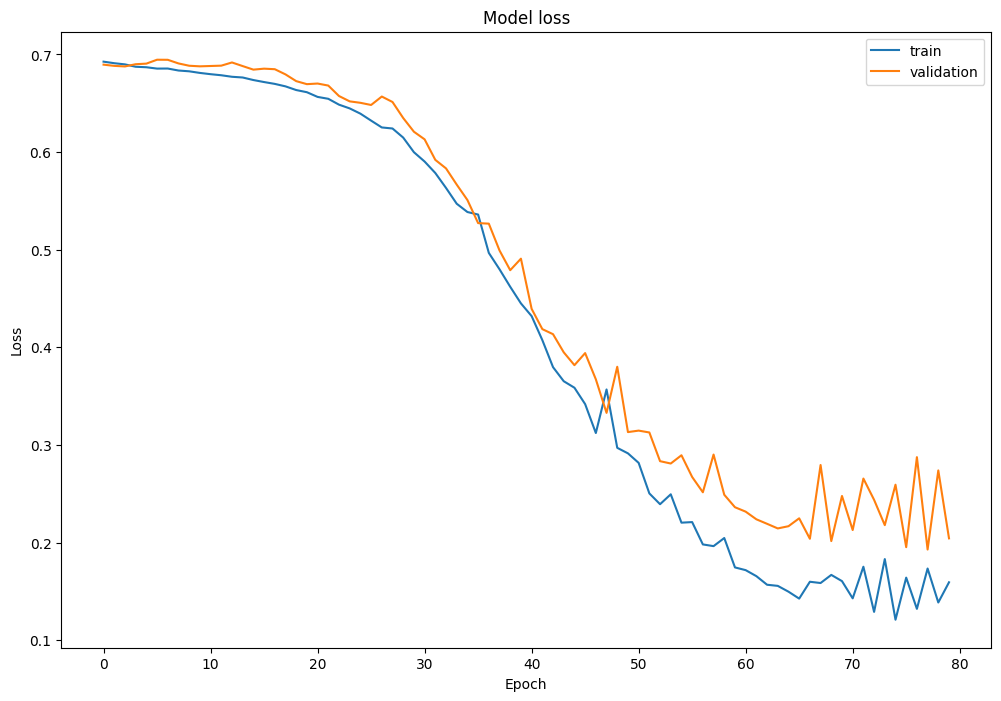

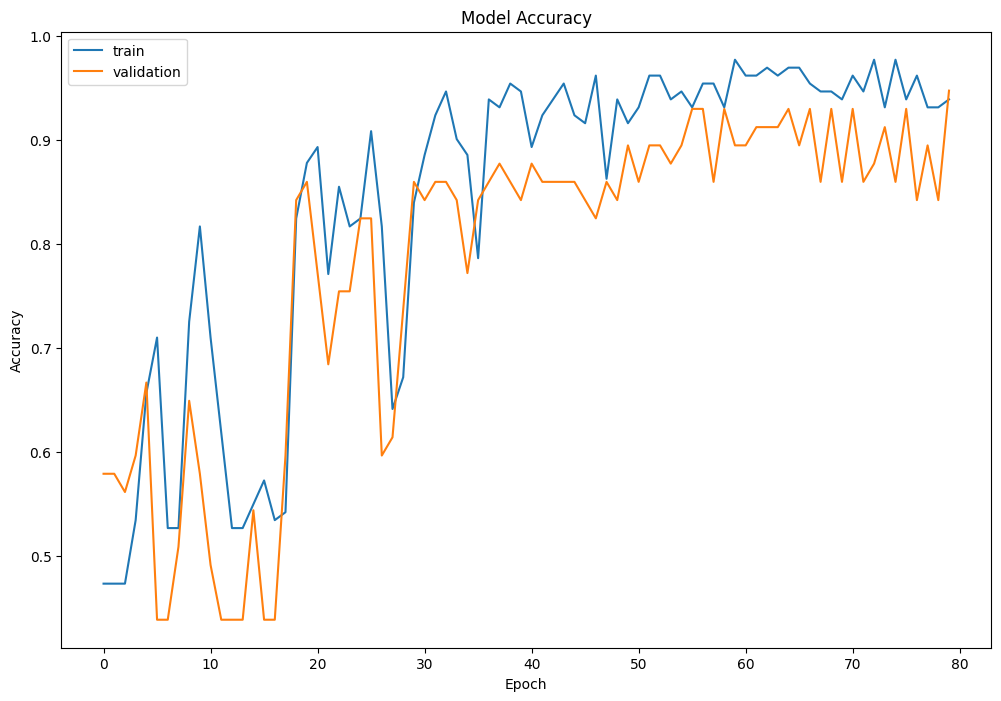

In [112]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [114]:
train_loss, train_accuracy = ConvModel.evaluate(X_train, Y_train)
test_loss, test_accuracy = ConvModel.evaluate(X_test, Y_test)


print(f"Accuracy of the training: {train_accuracy}")
print(f"Accuracy of the testing: {test_accuracy}")

if test_accuracy >= 0.85:
    ConvModel.save("CovidDetector.h5")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9029 - loss: 18.0090 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8752 - loss: 12.1547


Accuracy of the training: 0.9312977194786072
Accuracy of the testing: 0.859649121761322
